# Example: limited information case, linear system
In the following example we analyse the utility-privacy trade-off for a simple linear system in the limited information case. The system is described as follows
$$x_{t+1}=Ax_t+Ba_t +F\theta \mathbb{1}_{t\geq \nu} +w_t $$

where $w \sim \mathcal{N}(0, Q)$, with $Q=I_2$, $A=\begin{bmatrix}0 & 1\\1 & 1\end{bmatrix}$, $B=\begin{bmatrix}0.01\\1\end{bmatrix}$, $F=\begin{bmatrix}0.5 \\ 0.7\end{bmatrix}, \theta=1$.

The control law chosen by the user is $a_t=Kx_t + \alpha_t$ where $\alpha_t=\alpha_0$ for $t<\nu$ and $\alpha_t=\alpha_1$ for $t\geq \nu$. The control gain stabilizes the system, chosen as $K=\begin{bmatrix}-0.7 & -0.9\end{bmatrix}$.

In this example we investigate how to tune $(\alpha_0,\alpha_1)$ according to the utility-privacy value function.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#
# Copyright (c) 2021 Alessio Russo [alessior@kth.se]. All rights reserved.
#
# This file is part of PrivacyStochasticSystems.
#
# PrivacyStochasticSystems is free software: you can redistribute it and/or modify
# it under the terms of the MIT License. You should have received a copy of
# the MIT License along with PrivacyStochasticSystems.
# If not, see <https://opensource.org/licenses/MIT>.
#

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.linalg import solve_discrete_lyapunov


## Figures parameters
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "legend.fontsize": 14,
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ],
    'figure.figsize': [16, 4],
    'figure.dpi': 100
})


C:\Users\alessior\anaconda3\envs\PrivacyEnv\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## System definition and parameters

In [2]:
# Dimensions
n = 2
m = 1

# System matrices
A = np.array([[0, 1], [1, 1]])
B = np.array([[0.01], [1]])
F = np.array([[0.5], [0.7]])
Q = np.identity(n)
theta = 1
K = np.array([[-0.7, -0.9]])


Qinv = np.linalg.inv(Q)
L = np.identity(n) - A - B @ K
E = np.linalg.inv(L).T @ np.linalg.inv(L)

Sigma = solve_discrete_lyapunov((A+B@K), Q)

## Solve Utility-Privacy Trade off using CVXPY
In the following section we show results using the CVXPY Solver

In [3]:
# Functions definitiong
def SolveProb(rho, lmbd):
    alpha1 = cp.Variable((1,1))
    alpha0 = cp.Variable((1,1))
    z = (F*theta)
    V = rho *  cp.quad_form(alpha0, B.T @ E @ B) + np.trace(Sigma)
    V += (1-rho) * cp.quad_form( (B @ alpha1 + z), E)
    V += (lmbd/2) * cp.quad_form((z+ B @ (alpha1 - alpha0)), Qinv)
    problem = cp.Problem(cp.Minimize(V), [])
    problem.solve()
    return V.value, alpha0.value, alpha1.value

def compute_value(rho, alpha0, alpha1):
    V = rho *  alpha0 * B.T @ E @ B * alpha0 + np.trace(Sigma)
    V += (1-rho) * (B * alpha1 + F * theta).T @ E @ (B * alpha1 + F * theta)
    return V

def InformationValue(alpha0, alpha1):
    return 0.5 * (F*theta + B @ (alpha1-alpha0)).T @ Qinv @ (F*theta + B @ (alpha1-alpha0))

In [4]:
# Solve problem for different values of rho and lambda
RHO = np.linspace(0, 1, 4)
LMBD = np.linspace(1e-3, 3, 50)

A1 = np.zeros((len(RHO), len(LMBD)))
A0 = np.zeros((len(RHO), len(LMBD)))
I = np.zeros((len(RHO), len(LMBD)))
V = np.zeros((len(RHO), len(LMBD)))
for i in range(len(RHO)):
    for j in range(len(LMBD)):
        V[i,j], a0, a1 = SolveProb(RHO[i], LMBD[j])
        A0[i,j], A1[i,j] = a0, a1
        I[i,j] = InformationValue(a0, a1)


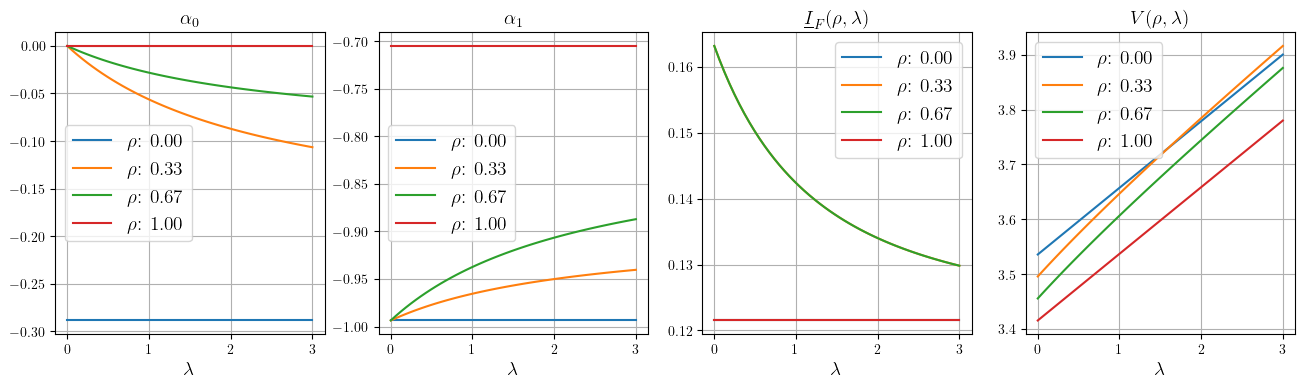

In [5]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=4)
titles = [r'$\alpha_0$', r'$\alpha_1$', r'$\underline{I}_F(\rho,\lambda)$', r'$V(\rho,\lambda)$']
for i in range(len(RHO)):
    ax[0].plot(LMBD, A0[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[1].plot(LMBD, A1[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[2].plot(LMBD, I[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[3].plot(LMBD, V[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))


for i in range(4):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel(r'$\lambda$', fontsize=14)
    ax[i].set_title(r'{}'.format(titles[i]), fontsize=14)
plt.show()

## Solve Utility-Privacy Trade-off using solutions in the paper
In this section we show results using the solutions from the paper.

In [6]:
# Define functions needed to compute alpha0 and alpha1
def Btilde(M, T):
    return np.linalg.inv(B.T @ (M + T) @ B) @ B.T @ M
    
def compute_alpha(rho, lmbd):
    a1 = -Btilde(rho * E @ B @ Btilde(Qinv, 2*rho*E/lmbd) + (1-rho)*E, 0) @ F * theta
    a0 = Btilde(Qinv, 2*rho*E/lmbd) @ (F * theta  + B @ a1)
    return (a0, a1)

In [7]:
A1 = np.zeros((len(RHO), len(LMBD)))
A0 = np.zeros((len(RHO), len(LMBD)))
I = np.zeros((len(RHO), len(LMBD)))
V = np.zeros((len(RHO), len(LMBD)))
for i in range(len(RHO)):
    for j in range(len(LMBD)):
        a0, a1 = compute_alpha(RHO[i], LMBD[j])
        I[i,j] = InformationValue(a0, a1)
        V[i,j] = compute_value(RHO[i], a0, a1) + LMBD[j] * I[i,j]
        A0[i,j], A1[i,j] = a0, a1

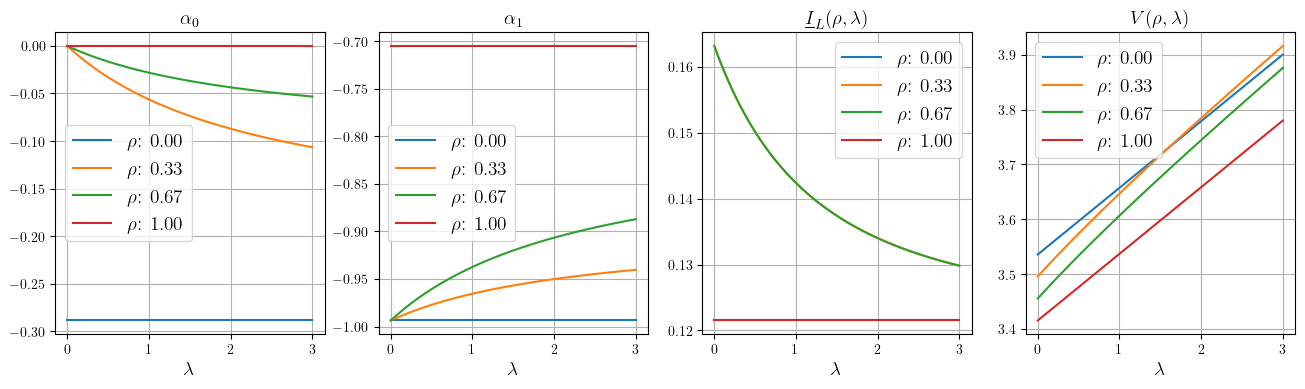

In [8]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=4)
titles = [r'$\alpha_0$', r'$\alpha_1$', r'$\underline{I}_L(\rho,\lambda)$', r'$V(\rho,\lambda)$']
for i in range(len(RHO)):
    ax[0].plot(LMBD, A0[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[1].plot(LMBD, A1[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[2].plot(LMBD, I[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))
    ax[3].plot(LMBD, V[i,:], label=r'$\rho$: {:.2f}'.format(RHO[i]))


for i in range(4):
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel(r'$\lambda$', fontsize=14)
    ax[i].set_title(r'{}'.format(titles[i]), fontsize=14)
plt.show()

## Contour plots
Contour plots for the best privacy level and the value utility function

In [9]:
# Solve problem for different values of rho and lambda
RHO = np.linspace(0, 1, 100)
LMBD = np.linspace(1e-3, 3, 100)
A1 = np.zeros((len(RHO), len(LMBD)))
A0 = np.zeros((len(RHO), len(LMBD)))
I = np.zeros((len(RHO), len(LMBD)))
V = np.zeros((len(RHO), len(LMBD)))
for i in range(len(RHO)):
    for j in range(len(LMBD)):
        a0, a1 = compute_alpha(RHO[i], LMBD[j])
        I[i,j] = InformationValue(a0, a1)
        V[i,j] = compute_value(RHO[i], a0, a1) #+ LMBD[j] * I[i,j]
        A0[i,j], A1[i,j] = a0, a1


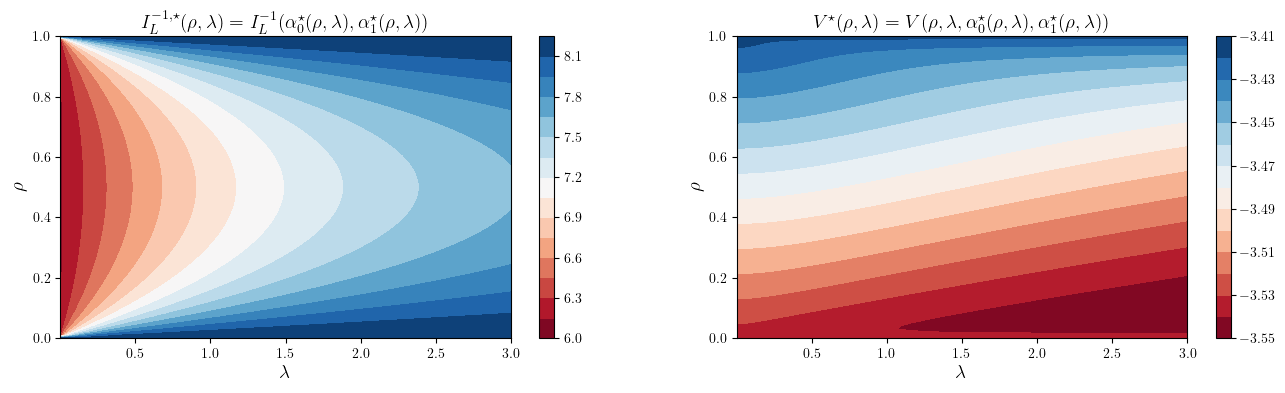

In [10]:
XI, YI = np.meshgrid(LMBD, RHO);

fig, ax = plt.subplots(nrows=1, ncols=2)
z = ax[0].contourf(XI,YI,1/I,levels=15,cmap='RdBu')
ax[0].set_xlabel(r'$\lambda$', fontsize=14)
ax[0].set_ylabel(r'$\rho$', fontsize=14)
ax[0].set_title(r'$I_L^{-1,\star}(\rho,\lambda) = I_L^{-1}(\alpha_0^\star(\rho,\lambda),\alpha_1^\star(\rho,\lambda))$', fontsize=14)
plt.colorbar(z, ax=ax[0])

z = ax[1].contourf(XI,YI,-V,levels=15,cmap='RdBu')
ax[1].set_xlabel(r'$\lambda$', fontsize=14)
ax[1].set_ylabel(r'$\rho$', fontsize=14)
ax[1].set_title(r'$V^\star(\rho,\lambda) = V(\rho,\lambda, \alpha_0^\star(\rho,\lambda),\alpha_1^\star(\rho,\lambda))$', fontsize=14)
plt.colorbar(z, ax=ax[1])
plt.show()